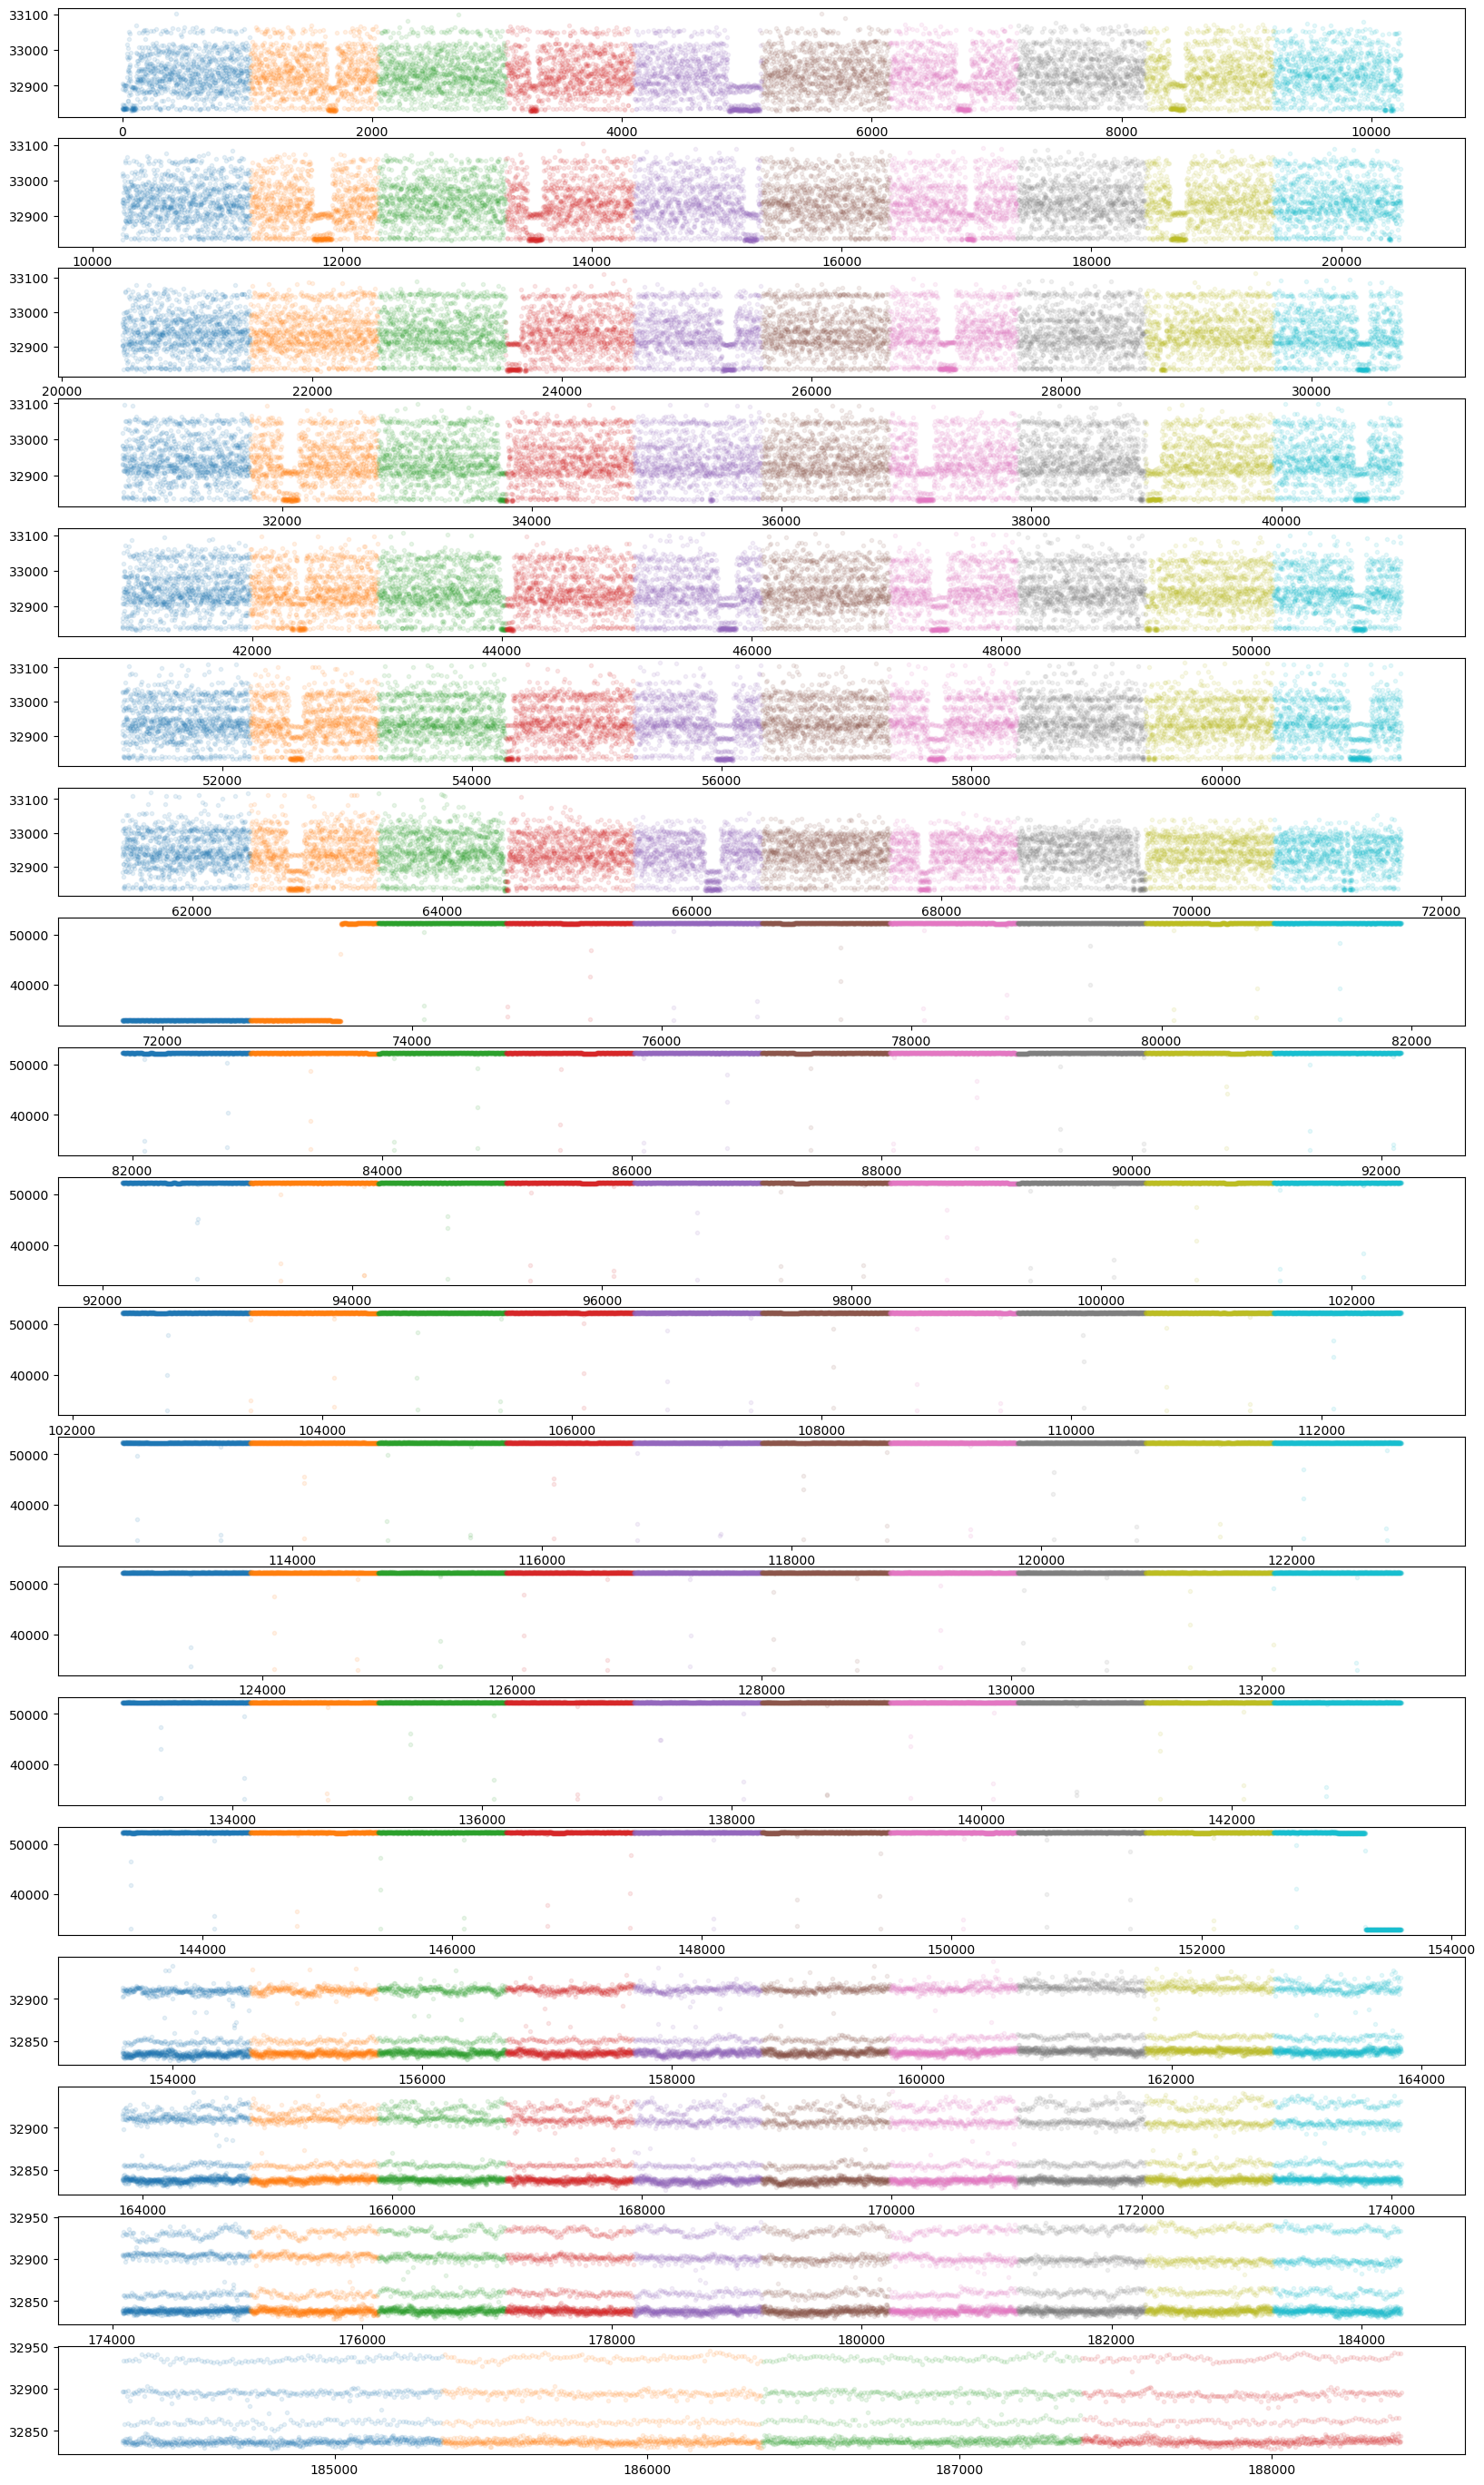

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# DOesnt work, its not even detecting a max, but it plots it..

# the aim is to count the triggers. The problemmight be that tey are sent as int16 so theya re unsigned

plt.figure(figsize=(20, 35))

start_file = 11
final_file = 195
n_files = final_file - start_file
x = np.arange(0, 1024*n_files, 1)
trigger_on_sequence = np.array([])
prev_idx = 0

just_triggered = False
w=0
for i in range(start_file, final_file):

    data = np.load(f'./saved/trg_ch_bf_{i}.npy').astype(np.int32)
    # print('   ')
    # print( data.max())
    start_idx = (i-start_file) * 1024
    end_idx = start_idx + 1024
    idx = (i-start_file)//10 + 1
    trigger_on_sequence = np.append(trigger_on_sequence, data)
    plt.subplot((n_files)//10 + 1, 1, idx, alpha=0.1)
    # if idx != prev_idx:
    #     print(f'idx: {idx}, prev_idx: {prev_idx}')
    #     prev_idx = idx
    plt.plot( x[start_idx:end_idx], data, '.', label=f'ch_bf_{i}', alpha=0.1)


    
    
    # print(f'Number of triggers in sequence {i}: {n_triggers}')




## Does it work in an normal sequence, ending in a trigger?

Number of triggers in sequence 113: 117


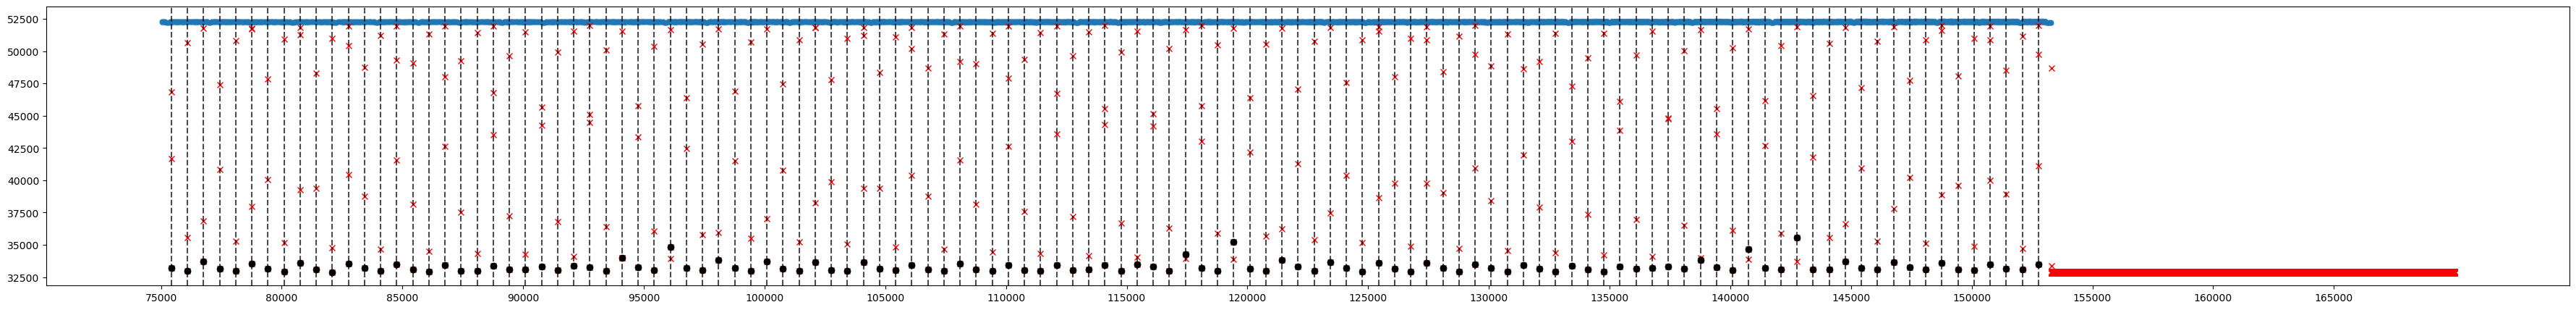

In [59]:
import numpy as np
import matplotlib.pyplot as plt



# the aim is to count the triggers. The problemmight be that tey are sent as int16 so theya re unsigned, thats why i got the am int32

plt.figure(figsize=(45, 5))


prev_idx = 0
just_triggered = False
w=0

start = 75000
end = 170000

# count triggers in sequence

n_triggers = 0
latest_diffs = np.array([]) # array to store the last 10 signal differences. If any of these is undoveer the 47000 threshold, we are still treating the same trigger
detected_trigger_idx = np.array([]) # array to store the indexes of the triggers detected
trigger_detect_threshold = 2000

for j in range(start, end-1):
    last_diff = trigger_on_sequence[j+1] - trigger_on_sequence[j]

    if last_diff >= trigger_detect_threshold:
        # if none of the latest 10 differences was above trigger_detect_threshold, then we have a new trigger
        if np.all(latest_diffs < trigger_detect_threshold):
            n_triggers += 1
            detected_trigger_idx = np.append(detected_trigger_idx, j)
        # if any of the latest 10 differences was above trigger_detect_threshold, we are still treating the same trigger
    latest_diffs = np.append(latest_diffs, last_diff)
    if latest_diffs.shape[0] > 10:
        latest_diffs = latest_diffs[1:]

plt.plot(x[start:end], trigger_on_sequence[start:end], '.', alpha=0.1)
plt.plot(x[start:end][trigger_on_sequence[start:end] < 52000], 
         trigger_on_sequence[start:end][trigger_on_sequence[start:end] < 52000], 
         'rx', alpha=1)
xticks = np.arange(start, end, step=5000)  # Adjust the step size as needed
plt.xticks(xticks, labels=xticks)

for idx in detected_trigger_idx.astype(int):
    plt.axvline(x=idx, color='k', linestyle='--', alpha=0.7)
plt.plot(x[detected_trigger_idx.astype(int)], trigger_on_sequence[detected_trigger_idx.astype(int)], 'ko', alpha=1)
    
print(f'Number of triggers in sequence {i}: {n_triggers}')

### Does it work on a sequence that was already triggering?
What shoudl be the expected behaviour? Only counting the upward spikes

In [2]:
import zmq
import os
import sys
import torch
import threading
import time
import json
import base64
import numpy as np
import logging
import queue
import pexpect

WINDOWS_OLD_MACHINE_IP = '172.17.17.125'

context = zmq.Context()
# Create the publishing socket
# pub_socket = context.socket(zmq.PUSH)
# pub_socket.connect(f"tcp://{WINDOWS_OLD_MACHINE_IP}:5556")

# Create the listening socket as a server
# pull_socket = context.socket(zmq.STREAM)

context = zmq.Context()

# Create a REQ socket as a client
WINDOWS_OLD_MACHINE_IP = '172.17.17.125'
req_socket = context.socket(zmq.REQ)
req_socket.connect(f"tcp://{WINDOWS_OLD_MACHINE_IP}:5557")

def generate_vec_file(img_ID, max_gray_trgs=10, max_img_trgs=10, ending_gray_trgs=10):
    """
    Parameters:
    img_ID (int): The image ID.
    max_gray_trgs (int): The number of lines representing the STARTING gray image.
    ending_gray_trgs (int): The number of lines representing the ENDING gray image.
    max_img_trgs (int): The number of lines representing triggers of the natural image.
    """

    lines = []

    lines.append(f"0 {max_gray_trgs+max_img_trgs+ending_gray_trgs} 0 0 0\n")
        # Write the following lines
    for _ in range(max_gray_trgs):
        lines.append("0 0 0 0 0\n")
    for _ in range(max_gray_trgs):
        lines.append(f"0 {img_ID} 0 0 0\n")            
    for _ in range(ending_gray_trgs):
        lines.append("0 0 0 0 0\n")  
    
    file_content = ''.join(lines)
              
    return file_content

def send_and_confirm( img_ID, finished_event, max_gray_trgs=10, max_img_trgs=10, ending_gray_trgs=10):
    '''
    Send to the client the VEC file corresponding the the chosen image ID and wait for confirmation. When received, set the event and allow the main thread to 
    Stop discarding packets
    '''
    print(f"   Sending new VEC file corresponding to image ID: {img_ID}")

    vec_content = generate_vec_file(img_ID=img_ID, max_gray_trgs=max_gray_trgs, max_img_trgs=max_img_trgs, ending_gray_trgs=ending_gray_trgs )
    # pub_socket.send_string(vec_content)
    # 
    # Send the VEC file to the client and wait for confirmation
    req_socket.send_string(vec_content)
    # confirmation = req_socket.recv_string()
    # if confirmation == 'CONFIRMED':
    #     # new_img_id_sent_event.set()
    #     logging.info(f"\n   Image ID sent to the client: {img_ID}")
    # else:
    #     logging.error(f"\n   Error: The client did not confirm the reception of the new image ID")

new_img_id_sent_event = threading.Event()

send_and_confirm( img_ID=1, finished_event=new_img_id_sent_event)



   Sending new VEC file corresponding to image ID: 1


Number of triggers in sequence 194: 2


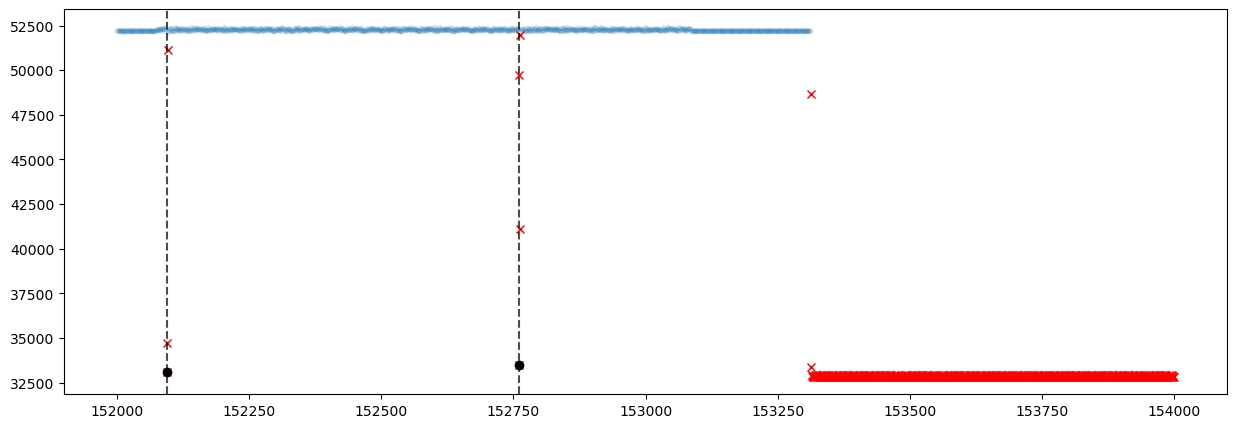

In [27]:
plt.figure(figsize=(15, 5))

start = 152000
end = 154000

# count triggers in sequence
n_triggers = 0
latest_diffs = np.array([]) # array to store the last 10 signal differences. If any of these is undoveer the 47000 threshold, we are still treating the same trigger
detected_trigger_idx = np.array([]) # array to store the indexes of the triggers detected
trigger_detect_threshold = 2000

for j in range(start, end-1):
    last_diff = trigger_on_sequence[j+1] - trigger_on_sequence[j]

    if last_diff >= trigger_detect_threshold:
        # if none of the latest 10 differences was above trigger_detect_threshold, then we have a new trigger
        if np.all(latest_diffs < trigger_detect_threshold):
            n_triggers += 1
            detected_trigger_idx = np.append(detected_trigger_idx, j)
        # if any of the latest 10 differences was above trigger_detect_threshold, we are still treating the same trigger
    latest_diffs = np.append(latest_diffs, last_diff)
    if latest_diffs.shape[0] > 10:
        latest_diffs = latest_diffs[1:]

plt.plot(x[start:end], trigger_on_sequence[start:end], '.', alpha=0.1)
plt.plot(x[start:end][trigger_on_sequence[start:end] < 52000], 
         trigger_on_sequence[start:end][trigger_on_sequence[start:end] < 52000], 
         'rx', alpha=1)


for idx in detected_trigger_idx.astype(int):
    plt.axvline(x=idx, color='k', linestyle='--', alpha=0.7)
plt.plot(x[detected_trigger_idx.astype(int)], trigger_on_sequence[detected_trigger_idx.astype(int)], 'ko', alpha=1)
    
print(f'Number of triggers in sequence {i}: {n_triggers}')

### Can I implement a counter for the amounts of triggers for the grey?
Assuming we always present 35 triggers in the gray then 50 of an image and 35 of gray again, we need to make sure I start counting the spikes only after the image has been presented

**Assuming all detected triggers have the same difference between each other.** If this is the case, as it appears from the following cell, we know that 35 triggers translate to 35*(time diffs btw triggers)

In [66]:
# Detect triggers idx of the whole sequence, just dont plot it
n_triggers = 0
latest_diffs = np.array([]) # array to store the last 10 signal differences. If any of these is undoveer the 47000 threshold, we are still treating the same trigger
detected_trigger_idx = np.array([]) # array to store the indexes of the triggers detected
trigger_detect_threshold = 2000

start = 000
end = 188000

for j in range(start, end-1):
    last_diff = trigger_on_sequence[j+1] - trigger_on_sequence[j]

    if last_diff >= trigger_detect_threshold:
        # if none of the latest 10 differences was above trigger_detect_threshold, then we have a new trigger
        if np.all(latest_diffs < trigger_detect_threshold):
            n_triggers += 1
            detected_trigger_idx = np.append(detected_trigger_idx, j)
        # if any of the latest 10 differences was above trigger_detect_threshold, we are still treating the same trigger
    latest_diffs = np.append(latest_diffs, last_diff)
    if latest_diffs.shape[0] > 10:
        latest_diffs = latest_diffs[1:]

trigger_diffs = np.array([])
for i in range(detected_trigger_idx.shape[0]-1):
    trigger_diffs = np.append(trigger_diffs, detected_trigger_idx[i+1] - detected_trigger_idx[i])
print(f'N of triggers detected {n_triggers}, Trigger max diff: {trigger_diffs.max()} trigger min diff: {trigger_diffs.min()} avg diff: {trigger_diffs.mean()}')

N of triggers detected 120, Trigger max diff: 667.0 trigger min diff: 666.0 avg diff: 666.655462184874


Given a sampling rate of r = 20kHz and a difference between triggers d = 666.7 detections we have

In [96]:
r = 2*1.e4
d = 666.7
tau = d/r
print(f'Time between triggers {tau*1.e3:.2f}ms')

# Number of triggers corresponfing to a grey image
max_grey_triggers = 35
max_img_triggers  = 50

print(f'{max_grey_triggers} triggers correspond to {max_grey_triggers*tau*1.e3:.2f}ms of Grey')

Time between triggers 33.34ms
35 triggers correspond to 1166.72ms of Grey


Number of triggers in sequence 118: 100


139428

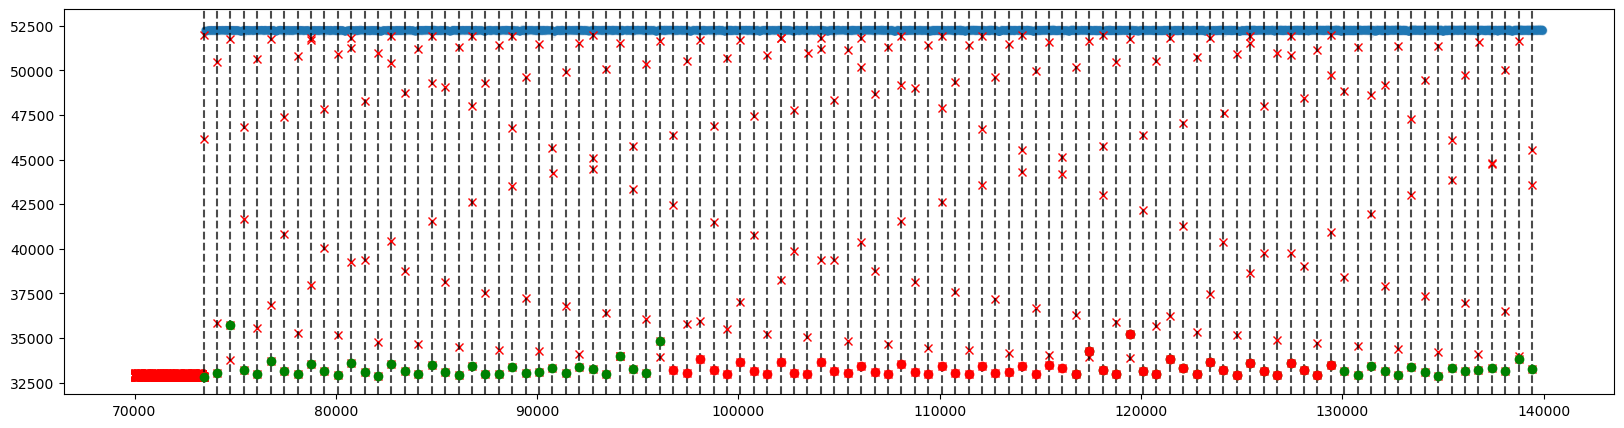

In [263]:
plt.figure(figsize=(20, 5))

start = 70000
end = 140000

# count triggers in sequence
n_triggers = 0

latest_diffs = np.array([]) # array to store the last 10 signal differences. If any of these is undoveer the 47000 threshold, we are still treating the same trigger
detected_trigger_idx = np.array([]) # array to store the indexes of the triggers detected

trigger_detect_threshold = 2000

for j in range(start, end-1):
    last_diff = trigger_on_sequence[j+1] - trigger_on_sequence[j]

    if last_diff >= trigger_detect_threshold:
        # if none of the latest 10 differences was above trigger_detect_threshold, then we have a new trigger
        if np.all(latest_diffs < trigger_detect_threshold):
            n_triggers += 1
            img_start_trg = j+1 # the last time this if gets executed, it will save the value of the first trigger of the target image
            detected_trigger_idx = np.append(detected_trigger_idx, j)
        # if any of the latest 10 differences was above trigger_detect_threshold, we are still treating the same trigger
    latest_diffs = np.append(latest_diffs, last_diff)
    if latest_diffs.shape[0] > 10:
        latest_diffs = latest_diffs[1:]
detected_trigger_idx = detected_trigger_idx.astype(int)

plt.plot(x[start:end], trigger_on_sequence[start:end], '.', alpha=0.1)
plt.plot(x[start:end][trigger_on_sequence[start:end] < 52000], 
         trigger_on_sequence[start:end][trigger_on_sequence[start:end] < 52000], 
         'rx', alpha=1)

for idx in detected_trigger_idx.astype(int):
    plt.axvline(x=idx, color='k', linestyle='--', alpha=0.7)

grey_idx = np.hstack( (detected_trigger_idx[0:max_grey_triggers], detected_trigger_idx[-max_grey_triggers:])  )
img_idx = detected_trigger_idx[max_grey_triggers:max_grey_triggers+max_img_triggers]

plt.plot(x[grey_idx], trigger_on_sequence[grey_idx], 'og', alpha=1)
plt.plot(x[img_idx], trigger_on_sequence[img_idx], 'or', alpha=1)



# plt.plot(x[detected_trigger_idx.astype(int)], trigger_on_sequence[detected_trigger_idx.astype(int)], 'ko', alpha=1)

    
print(f'Number of triggers in sequence {i}: {n_triggers}')
grey_idx[-1]

### Defining the function

Number of triggers in sequence 118: 2


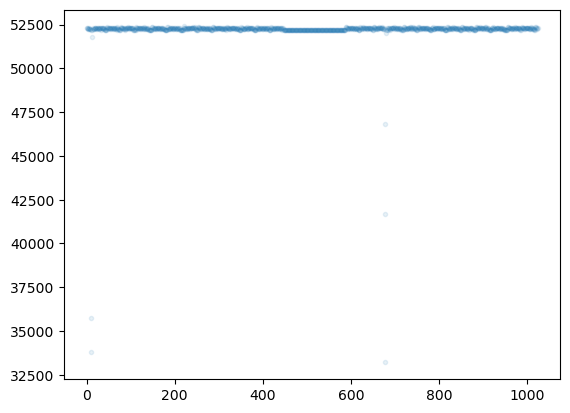

In [139]:
def count_triggers( trigger_ch_sequence, trigger_diff_threshold=2000):

    '''Counts the triggers in the provided array, tipically an quired buffer
    trigger_ch_sequence: np.array - the sequence of signals aquired from the trigger channel
    trigger_diff_threshold: int - the different threshold between two sonsecutive signals in the sequence to be considered a trigger

    '''
    start = 0
    end = trigger_ch_sequence.shape[0]

    # trigger counts in the sequence
    n_triggers = 0

    latest_diffs = np.array([]) # array to store the last 10 signal differences. If any of these is under the trigger threshold, we are still treating the same trigger
    detected_trigger_idx = np.array([]) # array to store the indexes of the triggers detected

    for j in range(start, end-1):
        last_diff = trigger_ch_sequence[j+1] - trigger_ch_sequence[j]

        if last_diff >= trigger_diff_threshold:
            # if none of the latest 10 differences was above trigger_diff_threshold, then we have a new trigger
            if np.all(latest_diffs < trigger_diff_threshold):
                n_triggers += 1
                img_start_trg = j+1 # the last time this if gets executed, it will save the value of the first trigger of the target image
                detected_trigger_idx = np.append(detected_trigger_idx, j)
            # if any of the latest 10 differences was above trigger_diff_threshold, we are still treating the same trigger
        latest_diffs = np.append(latest_diffs, last_diff)
        if latest_diffs.shape[0] > 10:
            latest_diffs = latest_diffs[1:]
    detected_trigger_idx = detected_trigger_idx.astype(int)

    return n_triggers, detected_trigger_idx
        

sequence_id = 84

buffer = np.load(f'./saved/trg_ch_bf_{sequence_id}.npy').astype(np.int32)

plt.plot( np.arange(0,buffer.shape[0]), buffer, '.', label=f'ch_bf_{i}', alpha=0.1)

n_triggers, _ = count_triggers(buffer, trigger_diff_threshold=2000)

print(f'Number of triggers in sequence {i}: {n_triggers}')


## Handling edge cases and descending triggers

To handle cases like the one in the below figure, just return a flag, in the function, to communicate if a trigger has been detected in the or last 10 detections.

To handle this case, where we know there will be a trigger cause of a descent in voltage, we need to add an np.abs to the diference detector.

Number of triggers in sequence 118: 1


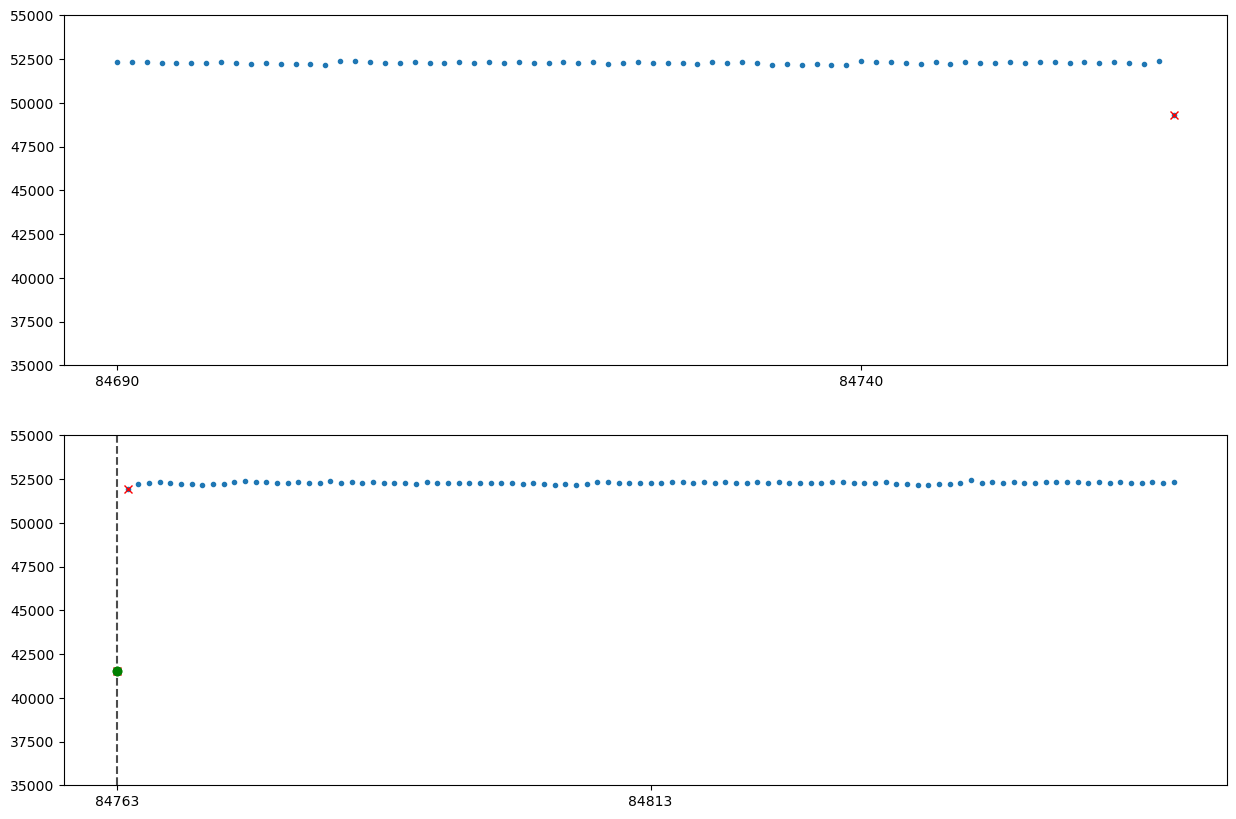

In [264]:
plt.figure(figsize=(15, 10))

start = 84690
end = start + 72

# count triggers in sequence
n_triggers = 0
#region
latest_diffs = np.array([]) # array to store the last 10 signal differences. If any of these is undoveer the 47000 threshold, we are still treating the same trigger
detected_trigger_idx = np.array([]) # array to store the indexes of the triggers detected

trigger_detect_threshold = 2000
trigger_close_to_end = False
for j in range(start, end-1):
    last_diff = (trigger_on_sequence[j+1] - trigger_on_sequence[j])

    if last_diff >= trigger_detect_threshold:
        # if none of the latest 10 differences was above trigger_detect_threshold, then we have a new trigger
        if np.all(latest_diffs < trigger_detect_threshold):
            n_triggers += 1
            img_start_trg = j+1 # the last time this if gets executed, it will save the value of the first trigger of the target image
            detected_trigger_idx = np.append(detected_trigger_idx, j)
            # if this trigger has been detected in the last 10 detections, flag the buffer
            if j - end < 10:
                trigger_close_to_end = True
            else:
                trigger_close_to_end = False    

    latest_diffs = np.append(latest_diffs, last_diff)
    if latest_diffs.shape[0] > 10:
        latest_diffs = latest_diffs[1:]
detected_trigger_idx = detected_trigger_idx.astype(int)

plt.subplot(2, 1, 1)
plt.plot(x[start:end], trigger_on_sequence[start:end], '.', alpha=1)
plt.plot(x[start:end][trigger_on_sequence[start:end] < 52000], 
         trigger_on_sequence[start:end][trigger_on_sequence[start:end] < 52000], 
         'rx', alpha=1)

for idx in detected_trigger_idx.astype(int):
    plt.axvline(x=idx, color='k', linestyle='--', alpha=0.7)

grey_idx = np.hstack( (detected_trigger_idx[0:max_grey_triggers], detected_trigger_idx[-max_grey_triggers:])  )
img_idx = detected_trigger_idx[max_grey_triggers:max_grey_triggers+max_img_triggers]

plt.plot(x[grey_idx], trigger_on_sequence[grey_idx], 'og', alpha=1)
plt.plot(x[img_idx], trigger_on_sequence[img_idx], 'or', alpha=1)
plt.xticks(np.arange(start, end, step=50),)

plt.ylim(35000, 55000)

plt.subplot(2, 1, 2)

start = end + 1
end = start + 100

# count triggers in sequence
n_triggers = 0

latest_diffs = np.array([]) # array to store the last 10 signal differences. If any of these is undoveer the 47000 threshold, we are still treating the same trigger
detected_trigger_idx = np.array([]) # array to store the indexes of the triggers detected

trigger_detect_threshold = 2000

for j in range(start, end-1):
    last_diff = np.abs(trigger_on_sequence[j+1] - trigger_on_sequence[j])

    if last_diff >= trigger_detect_threshold:
        # if none of the latest 10 differences was above trigger_detect_threshold, then we have a new trigger
        if np.all(latest_diffs < trigger_detect_threshold):
            n_triggers += 1
            detected_trigger_idx = np.append(detected_trigger_idx, j)
        # else: if any of the latest 10 differences was above trigger_detect_threshold, we are still treating the same trigger
    
    latest_diffs = np.append(latest_diffs, last_diff)
    if latest_diffs.shape[0] > 10:
        latest_diffs = latest_diffs[1:]
detected_trigger_idx = detected_trigger_idx.astype(int)

plt.subplot(2, 1, 2)
plt.plot(x[start:end], trigger_on_sequence[start:end], '.', alpha=1)
plt.plot(x[start:end][trigger_on_sequence[start:end] < 52000], 
         trigger_on_sequence[start:end][trigger_on_sequence[start:end] < 52000], 
         'rx', alpha=1)

for idx in detected_trigger_idx.astype(int):
    plt.axvline(x=idx, color='k', linestyle='--', alpha=0.7)

grey_idx = np.hstack( (detected_trigger_idx[0:max_grey_triggers], detected_trigger_idx[-max_grey_triggers:])  )
img_idx = detected_trigger_idx[max_grey_triggers:max_grey_triggers+max_img_triggers]

plt.plot(x[grey_idx], trigger_on_sequence[grey_idx], 'og', alpha=1)
plt.plot(x[img_idx], trigger_on_sequence[img_idx], 'or', alpha=1)
plt.ylim(35000, 55000)
#endregion
plt.xticks(np.arange(start, end, step=50),)
    
print(f'Number of triggers in sequence {i}: {n_triggers}')

By playing with the +1 + 2 +3 at line 40 we see tha tthe control with the flag works.

Number of triggers in sequence: 1, trigger close to end: True
72
Number of triggers in sequence: 1, trigger close to start: False


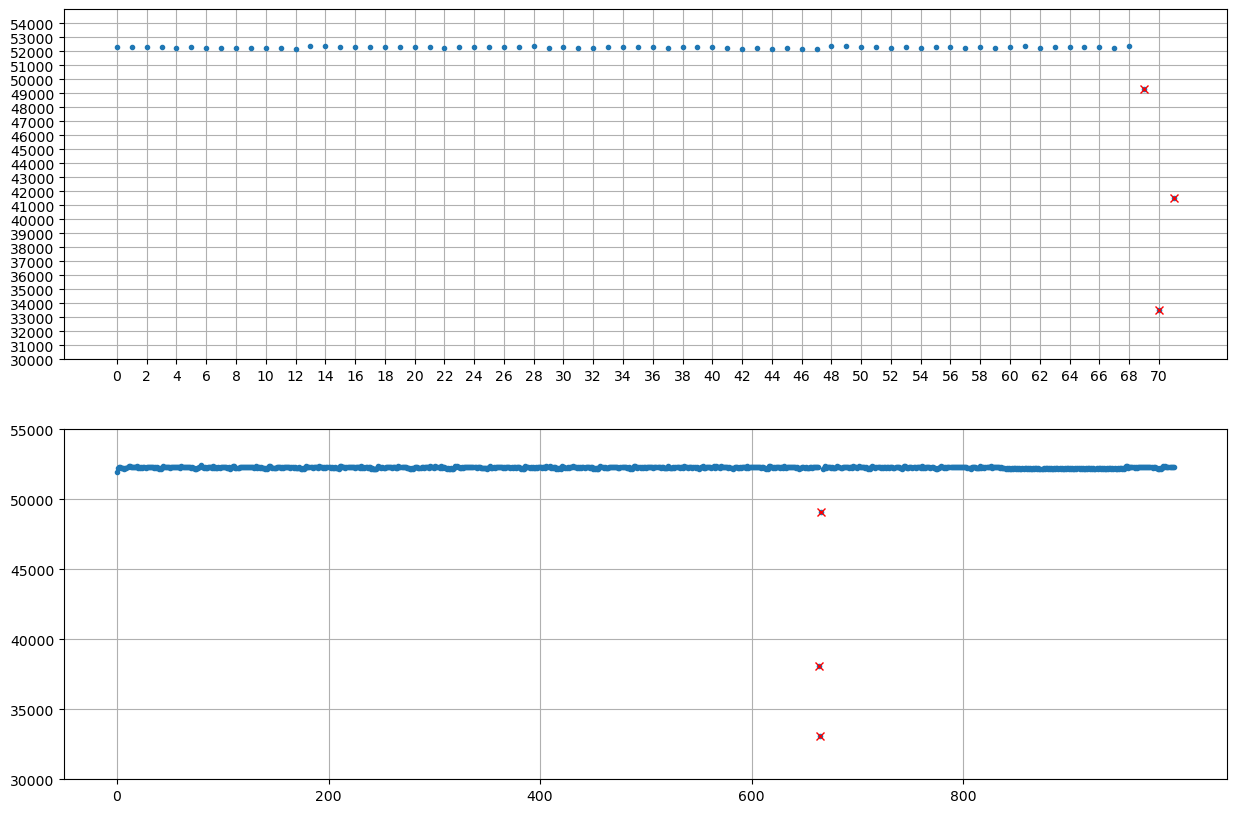

In [371]:
def count_triggers( trigger_ch_sequence, trigger_diff_threshold=2000, trigger_threshold=51000):

    '''Counts the triggers in the provided array, tipically an quired buffer
    trigger_ch_sequence: np.array - the sequence of signals aquired from the trigger channel
    trigger_diff_threshold: int - the different threshold between two sonsecutive signals in the sequence to be considered a trigger

    '''
    start = 0
    end = trigger_ch_sequence.shape[0]

    # trigger counts in the sequence
    n_triggers = 0

    latest_diffs = np.array([]) # array to store the last 10 signal differences. If any of these is under the trigger threshold, we are still treating the same trigger
    detected_trigger_idx = np.array([]) # array to store the indexes of the triggers detected
    trg_close_to_end   = False
    trg_close_to_start = False
    for j in range(start, end-1):
        last_diff = (trigger_ch_sequence[j+1] - trigger_ch_sequence[j])

        if last_diff >= trigger_diff_threshold:
            # if none of the latest 10 differences was above trigger_diff_threshold, then we have a new trigger
            if np.all(latest_diffs < trigger_diff_threshold):
                n_triggers += 1
                detected_trigger_idx = np.append(detected_trigger_idx, j)
            # if this trigger has been detected in the first or last 10 detections, flag the buffer
            if end-j < 10 :
                trg_close_to_end = True
            elif j < 10:
                trg_close_to_start = True

        latest_diffs = np.append(latest_diffs, last_diff)
        if latest_diffs.shape[0] > 10:
            latest_diffs = latest_diffs[1:]
    detected_trigger_idx = detected_trigger_idx.astype(int)

    return n_triggers, detected_trigger_idx, trg_close_to_end, trg_close_to_start

plt.figure(figsize=(15, 10))

start = 84690 +2
first_window = 72
end = start + first_window
trigger_threshold = 51000
# end = start + 10
plt.subplot(2, 1, 1)
buffer_ending_in_trigger = trigger_on_sequence[ start: end]
buffer = buffer_ending_in_trigger
# plt.plot( np.arange(0,buffer.shape[0]), buffer, '.', label=f'buffer ending in trigger', alpha=1)
plt.ylim(30000, 55000)
plt.plot(np.arange(0,buffer.shape[0]), trigger_on_sequence[start:end], '.', alpha=1)
plt.plot(np.arange(0,buffer.shape[0])[trigger_on_sequence[start:end] < trigger_threshold], 
         trigger_on_sequence[start:end][trigger_on_sequence[start:end] < trigger_threshold], 
         'rx', alpha=1)


n_triggers, idx, trg_close_to_end, _ = count_triggers(buffer, trigger_diff_threshold=2000)
print(f'Number of triggers in sequence: {n_triggers}, trigger close to end: {trg_close_to_end}')

plt.grid()
plt.xticks(np.arange(0, buffer.shape[0], step=2))
plt.yticks(np.arange(30000, 55000, step=1000))

print( len(buffer))

plt.subplot(2, 1, 2)
plt.grid()
start = end
second_window = 1000
end = start + second_window

buffer_starting_in_trigger = trigger_on_sequence[start:end]
buffer = buffer_starting_in_trigger
plt.ylim(30000, 55000)
plt.xticks(np.arange(0, buffer.shape[0], step=200))

plt.plot(np.arange(0,buffer.shape[0]), trigger_on_sequence[start:end], '.', alpha=1)
plt.plot(np.arange(0,buffer.shape[0])[trigger_on_sequence[start:end] < trigger_threshold], 
         trigger_on_sequence[start:end][trigger_on_sequence[start:end] < trigger_threshold], 
         'rx', alpha=1)


n_triggers, idx, _, trg_close_to_start= count_triggers(buffer, trigger_diff_threshold=2000)
if (trg_close_to_end and trg_close_to_start):
        n_triggers -= 1
        idx = idx[1:]
        

print(f'Number of triggers in sequence: {n_triggers}, trigger close to start: {trg_close_to_start}')


### What happens if there are not triggers?

count_triggers returns an empty arraay, what happens if i try slicing it? Nothing, the problem arises if i arr.max() it

In [383]:
def count_triggers( trigger_ch_sequence, trigger_diff_threshold=2000, trigger_threshold=51000):

    '''Counts the triggers in the provided array, tipically an quired buffer
    trigger_ch_sequence: np.array - the sequence of signals aquired from the trigger channel
    trigger_diff_threshold: int - the different threshold between two sonsecutive signals in the sequence to be considered a trigger

    '''
    start = 0
    end = trigger_ch_sequence.shape[0]

    # trigger counts in the sequence
    n_triggers = 0

    latest_diffs = np.array([]) # array to store the last 10 signal differences. If any of these is under the trigger threshold, we are still treating the same trigger
    detected_trigger_idx = np.array([]) # array to store the indexes of the triggers detected
    trg_close_to_end   = False
    trg_close_to_start = False
    for j in range(start, end-1):
        last_diff = (trigger_ch_sequence[j+1] - trigger_ch_sequence[j])

        if last_diff >= trigger_diff_threshold:
            # if none of the latest 10 differences was above trigger_diff_threshold, then we have a new trigger
            if np.all(latest_diffs < trigger_diff_threshold):
                n_triggers += 1
                detected_trigger_idx = np.append(detected_trigger_idx, j)
                # if this trigger has been detected in the first or last 10 detections, flag the buffer
                if end-j < 10 :
                    trg_close_to_end = True
                elif j < 10:
                    trg_close_to_start = True

        latest_diffs = np.append(latest_diffs, last_diff)
        if latest_diffs.shape[0] > 10:
            latest_diffs = latest_diffs[1:]
    detected_trigger_idx = detected_trigger_idx.astype(int)

    return n_triggers, detected_trigger_idx, trg_close_to_end, trg_close_to_start

plt.figure(figsize=(12, 4))

start = 84690 +2
first_window = 65
end = start + first_window
trigger_threshold = 51000
# end = start + 10
# plt.subplot(2, 1, 1)
buffer_ending_in_trigger = trigger_on_sequence[ start: end]
buffer = buffer_ending_in_trigger

# plt.ylim(30000, 55000)
# plt.plot(np.arange(0,buffer.shape[0]), trigger_on_sequence[start:end], '.', alpha=1)
# plt.plot(np.arange(0,buffer.shape[0])[trigger_on_sequence[start:end] < trigger_threshold], 
#          trigger_on_sequence[start:end][trigger_on_sequence[start:end] < trigger_threshold], 
#          'rx', alpha=1)


n_triggers, idx, trg_close_to_end, _ = count_triggers(buffer, trigger_diff_threshold=2000)
print(f'Number of triggers in sequence: {n_triggers}, trigger close to end: {trg_close_to_end}')

# plt.grid()
# plt.xticks(np.arange(0, buffer.shape[0], step=2))
# plt.yticks(np.arange(30000, 55000, step=2000))
# plt.show()

print(idx)
idx.shape


Number of triggers in sequence: 0, trigger close to end: False
[]


(0,)

<Figure size 1200x400 with 0 Axes>